# IKr fitting GA
**Written by Akwasi Darkwah Akwaboah**<br>
**01/20/2020**

**Clamping Protocol**

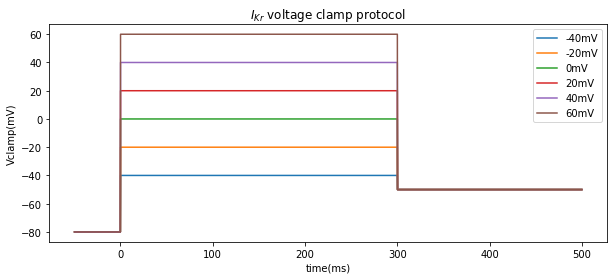

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Vcm = np.arange(-40, 61, 20) 
Vhold = -50  #mV
dt = 0.1  # time step
Vh_pre = -80    # mV,prepulse Holding Voltage
Vh_post = -50   # mV post holding
tStart = -50
tEnd = 500.0
nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
Vm = np.zeros((nStep + 1, 1), dtype=np.float)
plot_time = np.empty((nStep, 1), dtype=np.float)
plot_Vm = np.empty((nStep, len(Vcm)), dtype=np.float)
t = np.linspace(tStart, tEnd, nStep + 1)
i = 0  #column selector

for Vc in Vcm:
    tNow = tStart
    Vm[0] = Vh_pre
    for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            plot_Vm[iStep, i] = Vm[iStep]
            plot_time[iStep] = tNow
            tNow = tStart + iStep * dt
    i = i + 1 #increment to next clamp column

plt.figure(figsize = (10,4))
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{Kr}$ voltage clamp protocol')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')

#plt.grid()
plt.show()

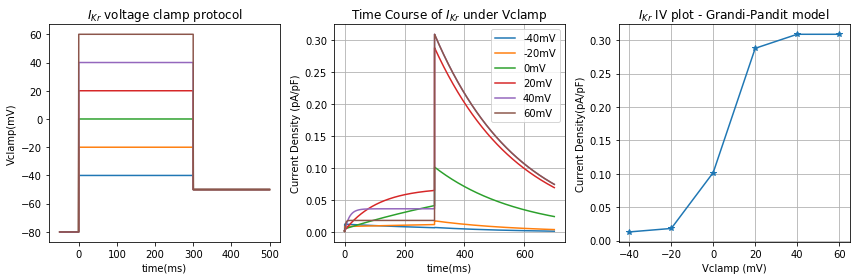

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def Ikr_func(K_gkr, a_xrss, b_xrss, a_txr, b_txr, c_txr, d_txr, e_txr, f_txr, g_txr, h_txr, j_txr, a_rkr, b_rkr):

    Vcm = np.arange(-40, 61, 20)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_post = -50   # mV post holding
    Ko = 5.4 #mM
    dt = 0.1  # time step
    tStart = -0.5000
    tEnd = 700.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables

    gKr = K_gkr * np.sqrt(Ko/ 5.4)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_xkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_rkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tauxr = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_IKr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        xkr = 0.044245060085  # initial condition
        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            xr_ss = 1 / (1 + np.exp(-(Vm[iStep] + a_xrss) / b_xrss))
            tau_xr = (a_txr/(1+np.exp(-(Vm[iStep]+b_txr)/c_txr)))*(d_txr/(1+np.exp((Vm[iStep]+e_txr)/f_txr))) + (g_txr/(1+np.exp((Vm[iStep]+h_txr)/j_txr)))
            dxkr = ((xr_ss - xkr)/ tau_xr)*dt
            r_kr = 1/(1+np.exp((Vm[iStep]+a_rkr)/b_rkr))
            IKr = gKr * xkr * r_kr * (Vm[iStep] - EK)
            Im = IKr + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xkr[iStep, i] = xkr
            plot_rkr[iStep, i] = r_kr
            plot_tauxr[iStep, i] = tau_xr
            plot_IKr[iStep, i] = IKr
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xkr = xkr+dxkr
            tNow = tStart + iStep * dt
        i = i + 1
    Ikr_peaks = np.max(plot_IKr, axis=0)
    return Ikr_peaks, plot_time, plot_IKr

plt.figure(figsize = (12,4))
plt.subplot(1,3,1)
plt.plot(plot_time[5:], plot_Vm[5:])
plt.xlabel('time(ms)')
plt.ylabel('Vclamp(mV)')
plt.title('$I_{Kr}$ voltage clamp protocol')
#plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')


Ikr_tails, time, plt_IKr = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)
Vcm = np.arange(-40, 61, 20)
plt.subplot(1, 3,3)
plt.plot(Vcm, Ikr_tails, '-*')
plt.xlabel('Vclamp (mV)')
plt.ylabel('Current Density(pA/pF)')
plt.title('$I_{Kr}$ IV plot - Grandi-Pandit model')
plt.grid()
#plt.show()

plt.subplot(1,3,2)
plt.plot(time, plt_IKr)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Course of $I_{Kr}$ under Vclamp')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.tight_layout()
plt.show()

***IKr function for GA, reduced computational time***

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def Ikr_func(K_gkr, a_xrss, b_xrss, a_txr, b_txr, c_txr, d_txr, e_txr, f_txr, g_txr, h_txr, j_txr, a_rkr, b_rkr):

    Vcm = np.arange(-40, 61, 20)    # mV, Command Voltage
    Vh_pre = -80    # mV,prepulse Holding Voltage
    Vh_post = -50   # mV post holding
    Ko = 5.4 #mM
    dt = 0.1  # time step
    tStart = -0.5000
    tEnd = 500.0
    nStep = np.int(np.ceil((tEnd - tStart) / dt))  # number of steps
    # Store the state variables

    gKr = K_gkr * np.sqrt(Ko/ 5.4)

    Vm = np.zeros((nStep + 1, 1), dtype=np.float)
    plot_xkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_rkr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_tauxr = np.zeros((nStep, len(Vcm)), dtype=np.float)

    plot_IKr = np.zeros((nStep, len(Vcm)), dtype=np.float)
    plot_time = np.empty((nStep, 1), dtype=np.float)
    plot_Im = np.empty((nStep, len(Vcm)), dtype=np.float)

    t = np.linspace(tStart, tEnd, nStep + 1)
    i = 0  #column selector

    for Vc in Vcm:
        tNow = tStart
        Vm[0] = Vh_pre
        xkr = 0.044245060085  # initial condition
        EK = -82.8  # mV, Potassium Nernst potential
        Cmem = 1.38e-10  # todo: Cmem value in appropriate orders
        for iStep in np.arange(nStep):
            Vm[iStep+1] = (tNow < 0.0)*Vh_pre + (0.0 <= tNow < 300.0) * Vc +  (tNow >= 300.0) * Vh_post
            xr_ss = 1 / (1 + np.exp((-Vm[iStep] + a_xrss) / b_xrss))
            tau_xr = (a_txr/(1+np.exp(-(Vm[iStep]+b_txr)/c_txr)))*(d_txr/(1+np.exp((Vm[iStep]+e_txr)/f_txr))) + (g_txr/(1+np.exp((Vm[iStep]+h_txr)/j_txr)))
            dxkr = ((xr_ss - xkr)/ tau_xr)*dt
            r_kr = 1/(1+np.exp((Vm[iStep]+a_rkr)/b_rkr))
            IKr = gKr * xkr * r_kr * (Vm[iStep] - EK)
            Im = IKr + Cmem*((Vm[iStep+1] - Vm[iStep]) / (t[iStep+1] - t[iStep]))

            plot_xkr[iStep, i] = xkr
            plot_rkr[iStep, i] = r_kr
            plot_tauxr[iStep, i] = tau_xr
            plot_IKr[iStep, i] = IKr
            plot_Im[iStep, i] = Im
            plot_time[iStep] = tNow
            xkr = xkr+dxkr
            tNow = tStart + iStep * dt
        i = i + 1
    Ikr_peaks = np.max(plot_IKr, axis=0)
    return Ikr_peaks, plot_time, plot_IKr

**GA**

generation:  0
1
[32]
32
0.3034307715932627
28
Runtime:  2.814457443333231 mins
[ 2.74238116e+00  2.02332795e+00  1.21943283e+00  3.39985484e+00
  1.97480783e+00  3.52939617e+00  3.62523125e+00  2.29838207e+00
  1.12376144e+00  1.88465039e+00  2.82109556e+00  1.59993690e+00
  1.88205568e+00  2.53250566e+00  2.26171529e+00  5.36626806e-01
  1.48996100e+00  1.74849399e+00  9.24757799e-01  5.23712303e-01
  3.04215473e+00  2.47099098e+00  3.53535167e+00  3.19877594e+00
  3.19544169e+00  2.90047532e+00  1.16653822e+00  3.48407903e+00
  2.82141501e+00  8.50211071e-01  3.40051854e+00  2.64408539e+00
 -1.00000000e+11  4.60502451e-01  2.97158062e+00  1.85781638e+00
  2.26581069e+00  1.54823626e+00  8.16146449e-01  2.62537136e+00
  3.47705655e+00  2.20705673e+00  2.36843531e+00  2.92457632e+00
  5.77910581e-01  2.48372105e+00  4.07528236e-01  1.36774685e+00
  1.07515494e+00  6.39652595e-01  8.23462127e-01  4.81041497e-01
  1.63949442e+00  3.96719215e-01  2.65929429e+00  1.09675425e+00
  1.459344

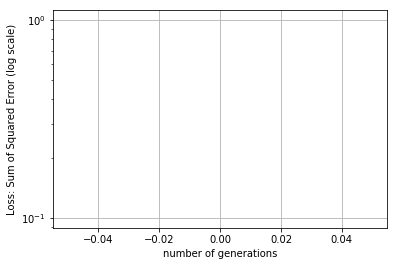

[7.55590954e-02 5.40203784e+00 7.76629563e+00 5.62604581e+02
 1.92748829e+01 1.07160606e+01 5.48476604e+00 1.48823958e+01
 8.91215161e+00 2.08375679e+02 4.02836001e+01 3.09878964e+01
 4.83668557e+01 2.03989866e+01]


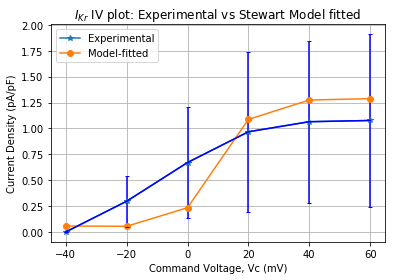

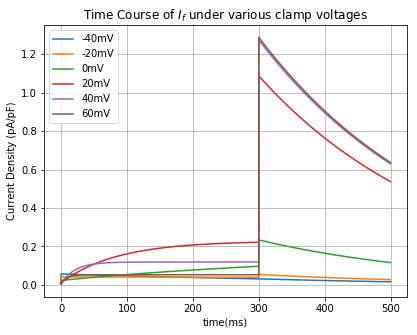

generation:  1
2
[ 58 114]
58
0.2711593411628894
28
generation:  2
2
[34 90]
34
0.24917063238619966
28
generation:  3
2
[ 56 112]
56
0.20491034613360593
28
generation:  4
2
[ 83 139]
83
0.16239780240402
28
generation:  5
2
[ 83 139]
83
0.13926036118925783
28
generation:  6
2
[ 45 101]
45
0.12061106120072579
28
generation:  7
2
[ 83 139]
83
0.10404404972756504
28
generation:  8
2
[ 47 103]
47
0.09069203392463508
28
generation:  9
2
[ 60 116]
60
0.07693149379242728
28
generation:  10
2
[ 49 105]
49
0.0691326298515348
28
Runtime:  30.621413955000026 mins
[ 7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.69314938e-02
  7.69314938e-02  7.69314938e-02  7.69314938e-02  7.

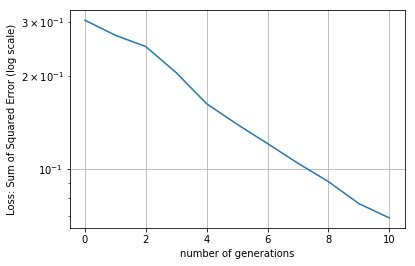

[ 7.02645232e-02 -2.16953040e+00  8.92398219e+00  5.78839245e+02
  1.92748829e+01  1.07160606e+01  5.48476604e+00  1.48823958e+01
  3.86688398e+00  2.08375679e+02  4.02836001e+01  3.09878964e+01
  5.09891436e+01  2.03989866e+01]


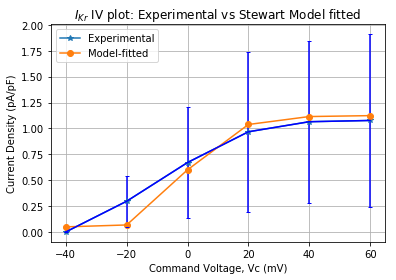

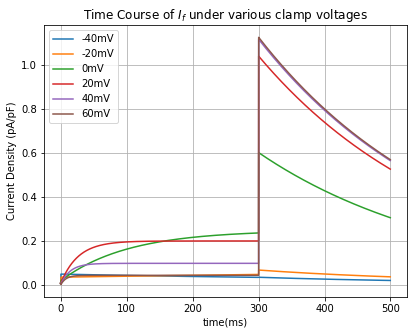

generation:  11
2
[ 47 103]
47
0.06346158582448577
28
generation:  12
2
[ 81 137]
81
0.05910659031431025
28
generation:  13
2
[ 66 122]
66
0.05655939424007442
28
generation:  14
2
[ 75 131]
75
0.052323073710317844
28
generation:  15
2
[ 64 120]
64
0.04950532362805027
28
generation:  16
2
[ 45 101]
45
0.046926197345733854
28
generation:  17
2
[ 77 133]
77
0.043400637978391034
28
generation:  18
2
[ 54 110]
54
0.03855061367743986
28
generation:  19
2
[ 81 137]
81
0.036001511309636615
28
generation:  20
2
[40 96]
40
0.034632960537538816
28
Runtime:  58.34109065666659 mins
[ 3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  3.60015113e-02  3.60015113e-02
  3.60015113e-02  3.60015113e-02  

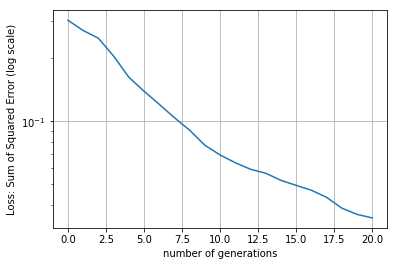

[ 6.85046427e-02 -5.22593815e+00  1.27948853e+01  5.62604581e+02
  1.92748829e+01  1.07160606e+01  3.21494820e+00  1.60699851e+01
  3.86688398e+00  2.08375679e+02  4.02836001e+01  3.09878964e+01
  4.67295478e+01  2.03989866e+01]


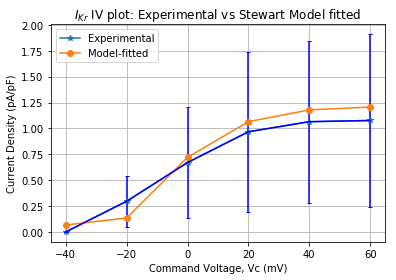

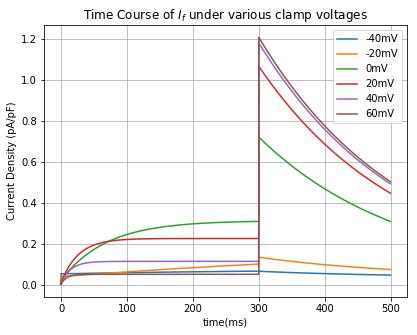

generation:  21
2
[ 65 121]
65
0.03209681534587041
28
generation:  22
2
[ 57 113]
57
0.026330825560838877
28
generation:  23
2
[ 74 130]
74
0.01993933013832641
28
generation:  24
2
[ 60 116]
60
0.014280692203910369
28
generation:  25
2
[38 94]
38
0.009194294230601982
28
generation:  26
2
[ 70 126]
70
0.007729908060972626
28
generation:  27
2
[ 46 102]
46
0.006440595359239866
28
generation:  28
2
[ 79 135]
79
0.005870138791353533
28
generation:  29
2
[ 62 118]
62
0.005631562220288874
28
generation:  30
2
[ 62 118]
62
0.005190617222075694
28
Runtime:  86.63123591333327 mins
[ 5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-03  5.63156222e-03  5.63156222e-03
  5.63156222e-03  5.63156222e-0

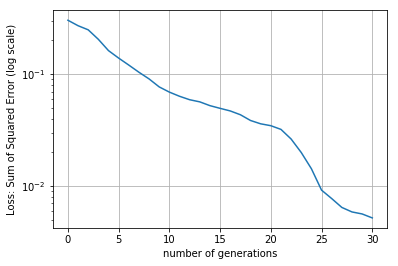

[ 6.79917315e-02 -6.33836738e+00  1.22105222e+01  5.62604581e+02
  1.92748829e+01  1.07160606e+01 -2.07306419e-01  1.60699851e+01
  3.86688398e+00  2.08375679e+02  4.02836001e+01  3.09878964e+01
  5.09891436e+01  2.20518199e+01]


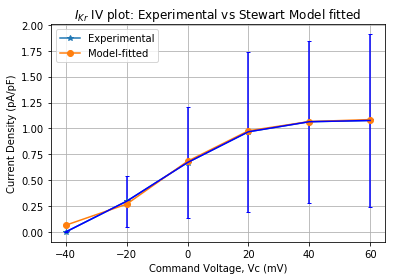

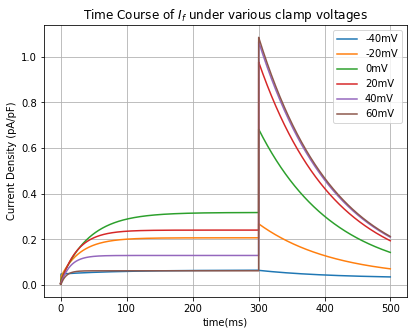

generation:  31
2
[ 45 101]
45
0.005120341614032304
28
generation:  32
2
[ 78 134]
78
0.005083328138611619
28
generation:  33
2
[ 44 100]
44
0.0050559857964689965
28
generation:  34
2
[43 99]
43
0.0050441257748623505
28
generation:  35
2
[ 83 139]
83
0.005015863076054136
28
generation:  36
2
[ 60 116]
60
0.004997692177382426
28
generation:  37
2
[ 82 138]
82
0.00497165649496381
28
generation:  38
2
[ 51 107]
51
0.004937588029076519
28
generation:  39
2
[ 69 125]
69
0.004916166250754981
28
generation:  40
2
[ 76 132]
76
0.004893575438018252
28
Runtime:  115.99461202166664 mins
[ 4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.91616625e-03  4.91616625e-03  4.91616625e-03
  4.91616625e-03  4.9161662

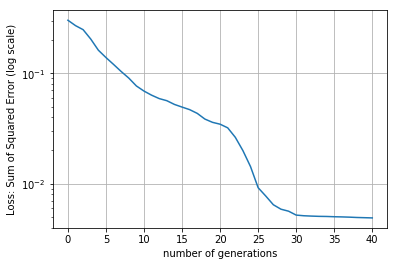

[ 6.75179737e-02 -6.45042035e+00  1.21224986e+01  5.62604581e+02
  1.92748829e+01  1.07160606e+01 -2.07306419e-01  1.60699851e+01
  2.75118468e-01  2.78582852e+02  3.90173783e+01  3.09878964e+01
  5.09891436e+01  2.03989866e+01]


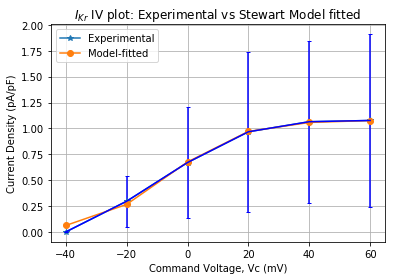

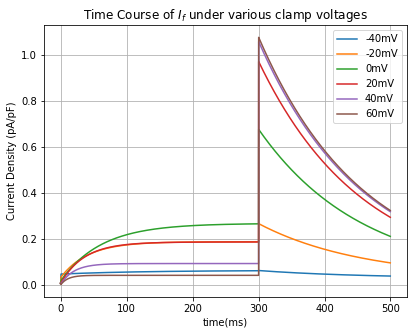

generation:  41
2
[ 73 129]
73
0.004873662404546429
28
generation:  42
2
[34 90]
34
0.004861370546452601
28
generation:  43
2
[ 67 123]
67
0.00483900285254501
28
generation:  44
2
[ 69 125]
69
0.004830977929299558
28
generation:  45
2
[ 51 107]
51
0.004809329592471278
28
generation:  46
2
[ 77 133]
77
0.00475066307926464
28
generation:  47
2
[ 61 117]
61
0.004698428156802417
28
generation:  48
2
[ 56 112]
56
0.004655282602010216
28
generation:  49
2
[ 45 101]
45
0.004583326647381521
28
generation:  50
2
[ 57 113]
57
0.004544749053348725
28
Runtime:  144.2686251799998 mins
[ 4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-03  4.58332665e-03  4.58332665e-03
  4.58332665e-03  4.58332665e-0

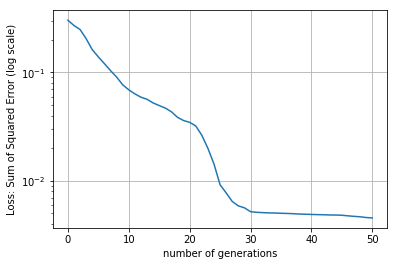

[ 6.75179737e-02 -6.80608093e+00  1.19589360e+01  5.58960904e+02
  2.11458793e+01  1.07160606e+01 -3.06202789e-01  1.60699851e+01
  2.75118468e-01  3.42041148e+02  3.44957360e+01  3.09878964e+01
  5.09891436e+01  2.03989866e+01]


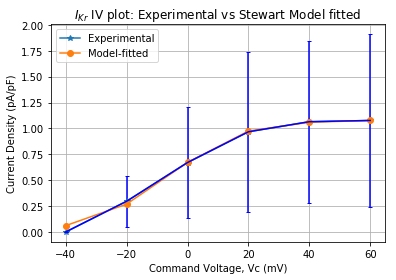

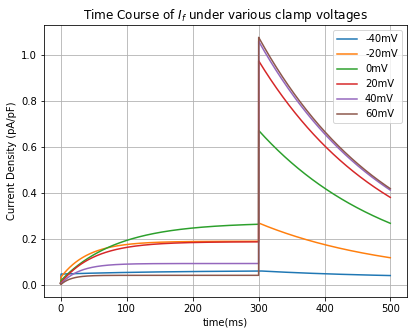

generation:  51
2
[ 63 119]
63
0.004521675856468599
28
generation:  52
2
[28 84]
28
0.004501023355699192
28
generation:  53
2
[35 91]
35
0.004478944969399239
28
generation:  54
2
[42 98]
42
0.004471556574105454
28
generation:  55
2
[ 65 121]
65
0.004424324675607268
28
generation:  56
2
[ 65 121]
65
0.00440114098409196
28
generation:  57
2
[ 71 127]
71
0.00437814970713595
28
generation:  58
2
[ 57 113]
57
0.0043550059996059366
28
generation:  59
2
[ 56 112]
56
0.0043418451166147756
28
generation:  60
2
[30 86]
30
0.004305286413195872
28
Runtime:  173.20864471999982 mins
[ 4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  4.34184512e-03  4.34184512e-03
  4.34184512e-03  4.34184512e-03  

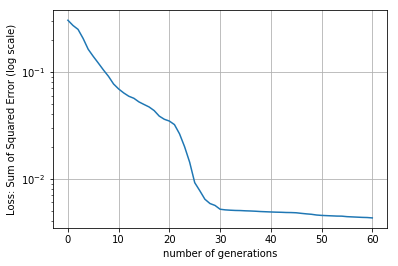

[ 6.75179737e-02 -7.13605217e+00  1.18860689e+01  5.62604581e+02
  2.11458793e+01  4.63866213e+00  2.54025509e-01  1.60699851e+01
  2.75118468e-01  3.59627970e+02  3.25483354e+01  3.09878964e+01
  5.09891436e+01  2.12867378e+01]


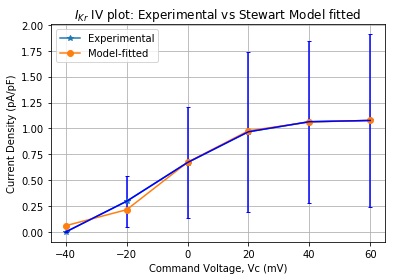

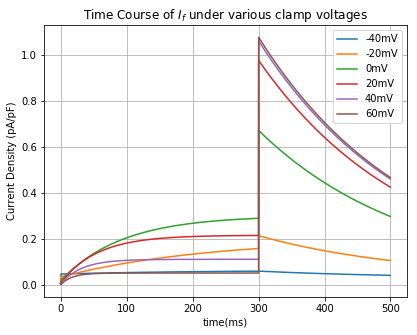

generation:  61
2
[ 69 125]
69
0.004275355169220088
28
generation:  62
2
[ 61 117]
61
0.00425096952472821
28
generation:  63
2
[ 62 118]
62
0.0042235345854698455
28
generation:  64
2
[ 72 128]
72
0.004199591391190038
28
generation:  65
2
[ 62 118]
62
0.004178740054216125
28
generation:  66
2
[ 66 122]
66
0.004156552977685163
28
generation:  67
2
[28 84]
28
0.004127376191176499
28
generation:  68
2
[ 76 132]
76
0.004094271318087637
28
generation:  69
2
[ 73 129]
73
0.004066240742810726
28
generation:  70
2
[ 63 119]
63
0.004050531845835006
28
Runtime:  202.43641962999996 mins
[ 4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074e-03  4.06624074e-03  4.06624074e-03
  4.06624074e-03  4.06624074

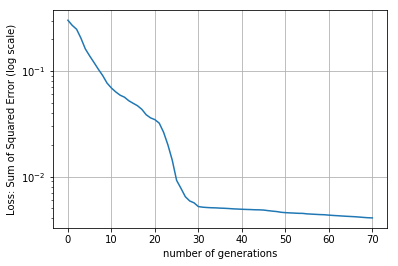

[ 6.75179737e-02 -7.36829965e+00  1.16130938e+01  5.62604581e+02
  2.20935149e+01  1.79874471e+00 -2.17298966e-01  1.60699851e+01
  2.75118468e-01  3.99170213e+02  3.25483354e+01  3.24424331e+01
  5.09891436e+01  2.12867378e+01]


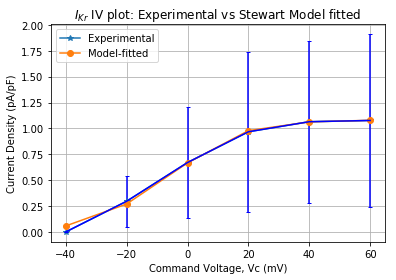

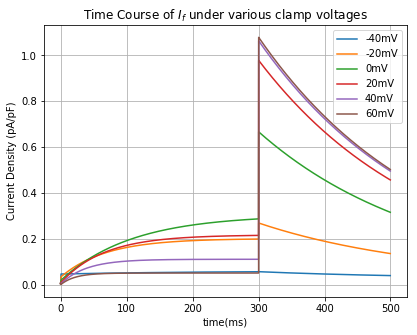

generation:  71
2
[ 58 114]
58
0.004039661462920882
28
generation:  72
2
[31 87]
31
0.003993453627578747
28
generation:  73
2
[ 71 127]
71
0.0039049183578054687
28
generation:  74
2
[ 47 103]
47
0.003856560472548592
28
generation:  75
2
[ 61 117]
61
0.0038365859950107474
28
generation:  76
2
[ 76 132]
76
0.003834128863796521
28
generation:  77
2
[ 71 127]
71
0.003789414217308999
28
generation:  78
2
[ 56 112]
56
0.003661471556220324
28
generation:  79
2
[ 56 112]
56
0.0035878514226047884
28
generation:  80
2
[ 74 130]
74
0.0034521418120797595
28
Runtime:  231.46362155999984 mins
[ 3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.58785142e-03  3.58785142e-03  3.58785142e-03
  3.58785142e-03  3.5878

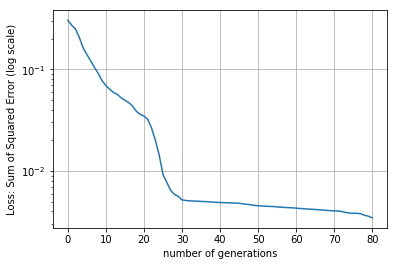

[ 6.75179737e-02 -8.27530087e+00  1.09651390e+01  5.62604581e+02
  2.20935149e+01  1.79874471e+00 -3.41704934e-01  1.60699851e+01
  2.75118468e-01  4.33852008e+02  3.25483354e+01  3.61620570e+01
  5.09891436e+01  2.12867378e+01]


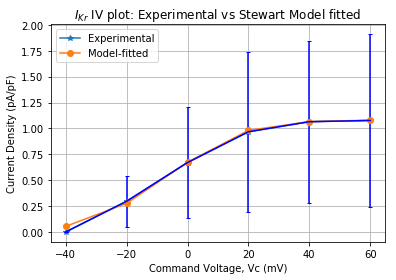

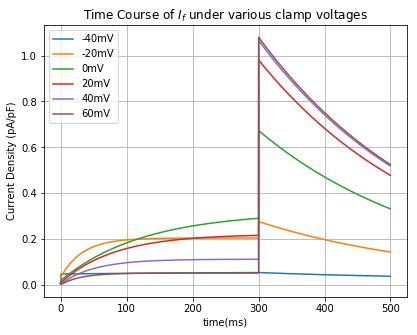

generation:  81
2
[ 79 135]
79
0.0034117507856496186
28
generation:  82
2
[34 90]
34
0.003406922596263467
28
generation:  83
2
[34 90]
34
0.0033198449128115336
28
generation:  84
2
[ 73 129]
73
0.003270753166712219
28
generation:  85
2
[ 67 123]
67
0.0031787394133567333
28
generation:  86
2
[ 75 131]
75
0.003157932844055141
28
generation:  87
2
[ 48 104]
48
0.003157384733227868
28
generation:  88
2
[ 47 103]
47
0.003094374687484372
28
generation:  89
2
[ 47 103]
47
0.003083115423632754
28
generation:  90
2
[ 70 126]
70
0.0030436700721727223
28
Runtime:  260.7871436416664 mins
[ 3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.08311542e-03  3.08311542e-03  3.08311542e-03
  3.08311542e-03  3.0831154

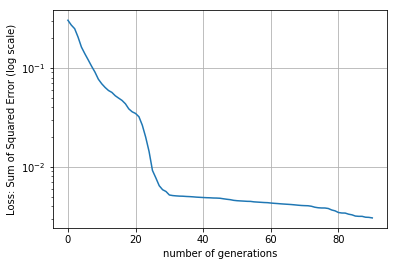

[ 6.75179737e-02 -8.85697483e+00  1.06049285e+01  5.62604581e+02
  2.25604904e+01  8.48479199e-01 -3.41704934e-01  1.60699851e+01
  2.75118468e-01  4.74346870e+02  3.25483354e+01  3.82699245e+01
  5.09891436e+01  2.09719665e+01]


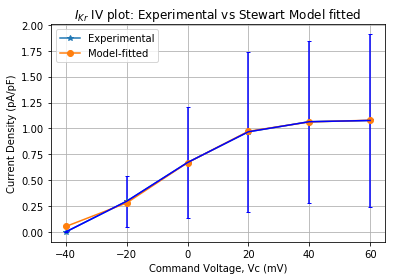

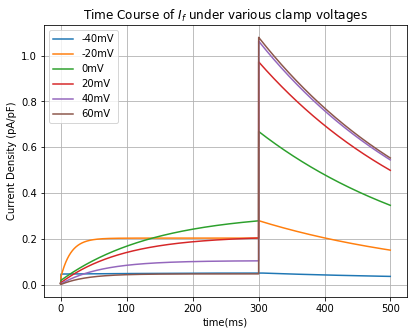

generation:  91
2
[ 56 112]
56
0.0030291161287345934
28
generation:  92
2
[ 74 130]
74
0.0030163513128609295
28
generation:  93
2
[ 56 112]
56
0.0030159112121404623
28
generation:  94
2
[ 78 134]
78
0.002960812293753569
28
generation:  95
2
[ 46 102]
46
0.00292887966818352
28
generation:  96
2
[35 91]
35
0.0029276751821650784
28
generation:  97
2
[ 78 134]
78
0.002868640690526283
28
generation:  98
2
[ 82 138]
82
0.0027797888587784633
28
generation:  99
2
[ 44 100]
44
0.00277862125587884
28
generation:  100
2
[36 92]
36
0.0027759950929153675
28
Runtime:  289.5367191849997 mins
[ 2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.77862126e-03  2.77862126e-03  2.77862126e-03
  2.77862126e-03  2.778621

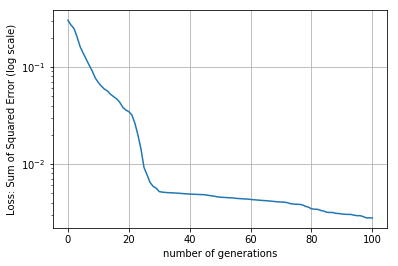

[ 6.75179737e-02 -9.23225436e+00  1.00224281e+01  5.62604581e+02
  2.20935149e+01  2.05617335e-01 -3.41704934e-01  1.60699851e+01
  3.15075992e-01  4.90484972e+02  3.08905343e+01  3.91636784e+01
  5.09891436e+01  2.09719665e+01]


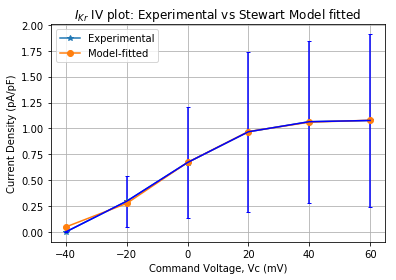

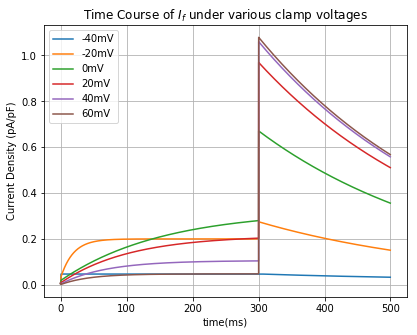

generation:  101
2
[30 86]
30
0.0027756376218613607
28
generation:  102
2
[ 71 127]
71
0.0027323241951909896
28
generation:  103
2
[ 63 119]
63
0.002682671762795759
28
generation:  104
2
[ 82 138]
82
0.002664263409137923
28
generation:  105
2
[39 95]
39
0.0026451886792468325
28
generation:  106
2
[ 79 135]
79
0.002643074346017786
28
generation:  107
2
[32 88]
32
0.0026419831053420533
28
generation:  108
2
[ 57 113]
57
0.002572183572444391
28
generation:  109
2
[ 73 129]
73
0.00256566952752079
28
Best Solution:  [ 6.75179737e-02 -9.83652303e+00  9.90973440e+00  5.62604581e+02
  2.20935149e+01  2.05617335e-01 -3.41704934e-01  1.60699851e+01
  2.75118468e-01  5.01257708e+02  2.94536945e+01  3.88241811e+01
  5.09891436e+01  2.11917333e+01]
Best solution fitness:  0.0025609971600630025


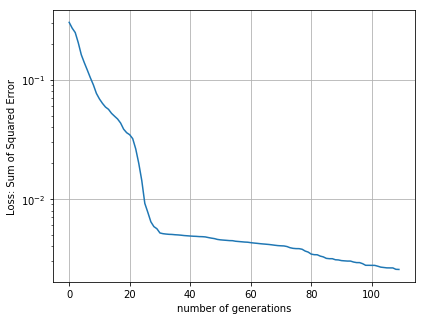

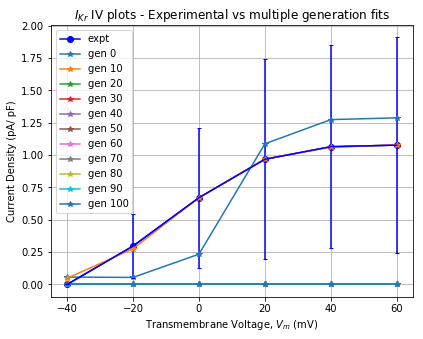

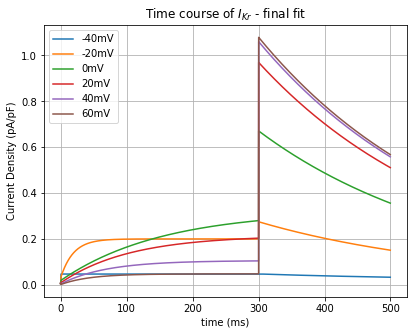

In [14]:
import timeit

timer_start = timeit.default_timer()
# inputs, x
V = np.arange(-40, 61, 20)    # mV, Command Voltage

# actual Y
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

# Population
# Parameter initialization
C = np.empty((140, 14))
C[:, 0] = np.random.uniform(0, 0.1, C.shape[0])     #g
C[:, 1] = np.random.uniform(5, 15, C.shape[0]) #ax
C[:, 2] = np.random.uniform(3, 8, C.shape[0])     #bx
C[:, 3] = np.random.uniform(500, 600, C.shape[0])     #ex
C[:, 4] = np.random.uniform(15, 27, C.shape[0])       #ta
C[:, 5] = np.random.uniform(7, 12, C.shape[0])         #td
C[:, 6] = np.random.uniform(4, 9, C.shape[0])      #te
C[:, 7] = np.random.uniform(8, 15, C.shape[0])         #tf
C[:, 8] = np.random.uniform(7, 12, C.shape[0])      #ti
C[:, 9] = np.random.uniform(200, 280, C.shape[0])         #tj
C[:, 10] = np.random.uniform(30, 60, C.shape[0])       #tk
C[:, 11] = np.random.uniform(5, 40, C.shape[0])         #tn
C[:, 12] = np.random.uniform(50, 85, C.shape[0])          #tp
C[:, 13] = np.random.uniform(10, 30, C.shape[0])           #ra

##population = np.transpose(C)

Ikr = np.empty((C.shape[0], 6))
population = C  # initial Population

# fitness
def pop_fitness(ppln):
    for i in range(C.shape[0]):
        Ikr[i,:], time, plt_Ikr = Ikr_func(ppln[i, 0], ppln[i, 1], ppln[i, 2], ppln[i, 3], ppln[i, 4],
                                 ppln[i, 5], ppln[i, 6], ppln[i, 7], ppln[i, 8], ppln[i, 9],
                                 ppln[i, 10], ppln[i, 11], ppln[i, 12], ppln[i, 13])
    SSE = np.sum((Ikr - Ikr_act) ** 2, axis=1)
    return SSE


def select_mating_pool(popn, fitness, num_parents):
    parents = np.empty((num_parents, popn.shape[1]))
    for parent_no in range(num_parents):
        max_fit_idx = np.where(fitness == np.min(fitness))  # find max and return its index
        max_fit_idx = max_fit_idx[0][0]  # Select the first index if repetitive
        parents[parent_no, :] = popn[max_fit_idx, :]
        fitness[max_fit_idx] = -99999999999
    return parents


# todo: Vary the crossover point randomly or set it to the typical middle point ie offspring[1]/2
def crossover(parents,
              offspring_size):  # in the case offspring size = (k, 3) where k is the number of desired offsprings
    offspring = np.empty(offspring_size)
    #pt1 = np.random.randint(1, offspring_size[1]/2)  # randomize the crossover point, typically the middle is chosen
    #pt2
    #crossover_point1 = np.uint8(offspring_size[1] / pt)
    crossover_point1 = np.uint8(np.random.randint(1, offspring_size[1]/2))
    crossover_point2 = np.uint8(np.random.randint(offspring_size[1]/2, offspring_size[1]))

    for n in range(parents.shape[0]):
        # parent selection
        parent1_idx = n % parents.shape[0]  # using modulus helps implement a ring parent selection fashion
        parent2_idx = (n + 1) % parents.shape[0]
        # offspring will have a up to the crossover point proportion from parent1 and parent2 respectively
        # Actual crossover
        # todo: generate two offsprings instead of one
        offspring[n, 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n, crossover_point1:crossover_point2] = parents[parent2_idx, crossover_point1:crossover_point2]
        offspring[n, crossover_point2:] = parents[parent1_idx, crossover_point2:]
        #second offspring
        offspring[n + parents.shape[0], 0:crossover_point1] = parents[parent1_idx, 0:crossover_point1]
        offspring[n + parents.shape[0], crossover_point1:]  = parents[parent2_idx, crossover_point1:]
    return offspring


def mutation(offspring_crossover):
    # single gene random change per offspring
    for idx in range(offspring_crossover.shape[0]):
        gene_select = np.random.randint(0, population.shape[1])  # vary range of random value for gene variation
        rand_mutn_val =( (gene_select == 0)*np.random.uniform(-0.01, 0.01) +    #gkr
                         (gene_select == 1)*np.random.uniform(-2, 2) +      #xa
                         (gene_select == 2)*np.random.uniform(-1.5, 1.5) +          #xd
                         (gene_select == 3)*np.random.uniform(-20, 20) +          #xe
                         (gene_select == 4)*np.random.uniform(-2.0, 2.0) +        #ta
                         (gene_select == 5)*np.random.uniform(-2.0, 2.0) +          #td
                         (gene_select == 6)*np.random.uniform(-1.0, 1.0) +      #te
                         (gene_select == 7)*np.random.uniform(-2.0, 2.0) +      #tf
                         (gene_select == 8)*np.random.uniform(-2.0, 2.0) +          #ti
                         (gene_select == 9)*np.random.uniform(-20, 20) +      #tj
                         (gene_select == 10)*np.random.uniform(-2, 2) +       #tk
                         (gene_select == 11)*np.random.uniform(-1.5, 1.5) +         #tn
                         (gene_select == 12)*np.random.uniform(-5, 5) +         #tp
                         (gene_select == 13)*np.random.uniform(-2, 2)     #ra
                         )
        # todo: try mutating some offsprings and not all
        offspring_crossover[idx, gene_select] = offspring_crossover[idx, gene_select] + rand_mutn_val
    return offspring_crossover

i_plt = 0
gen_mod = 10
num_of_gens = 110
no_plts = num_of_gens/gen_mod
no_plts = np.int16(no_plts)
gen_curr_arr = np.zeros((6, num_of_gens))
num_mating_parents = int(C.shape[0]/5)

best_gen_fitness = []
for generation in range(num_of_gens):
    print('generation: ', generation)
    fitness = pop_fitness(population)  # calculate fitness (SSE)
    #print(fitness)
    fitness = np.where(np.isnan(fitness), 1e100, fitness) #handles the dreaded nan's
    #fitness = np.where(np.isinf(fitness), 0, fitness)
    best_gn_fit_idx = np.where(fitness == np.min(fitness))
    print(best_gn_fit_idx[0].size)
    print(best_gn_fit_idx[0])
    if best_gn_fit_idx[0].size == 0:
        indx = np.random.randint(0, C.shape[0])
    else:
        indx = best_gn_fit_idx[0][0]
        
    print(indx)
    print(fitness[indx])
    best_gen_fitness.append(fitness[indx])
    parents = select_mating_pool(population, fitness, num_mating_parents)  # choose mating parents based on best min SSE
    print(parents.shape[0])
    offspring_crossed = crossover(parents, offspring_size=(2*parents.shape[0], population.shape[1]))
    offspring_mutated = mutation(offspring_crossed)
    # assumption in the above 3 lines, the number of parents, offsprings and mutants are same
    # create new population with parents, offsprings and their mutants
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]: 3 * parents.shape[0], :] = offspring_crossed
    population[3 * parents.shape[0]:, :] = offspring_mutated


    if generation%gen_mod == 0:
        best_gn_fit_idx = np.where(fitness == np.min(fitness))
        b_idx = best_gn_fit_idx
        gen_num = np.arange(len(best_gen_fitness))
        timer_stop = timeit.default_timer()
        print('Runtime: ', (timer_stop - timer_start)/60.0, 'mins')
        print(fitness)
        plt.plot(gen_num, best_gen_fitness)
        plt.xlabel('number of generations')
        plt.ylabel('Loss: Sum of Squared Error (log scale)')
        plt.yscale('log')
        plt.grid()
        plt.show()
        y_fit, time_fit, plt_Ikr_fit = Ikr_func(population[b_idx, 0], population[b_idx, 1], population[b_idx, 2],
                               population[b_idx, 3], population[b_idx, 4], population[b_idx, 5],
                               population[b_idx, 6], population[b_idx, 7], population[b_idx, 8],
                               population[b_idx, 9], population[b_idx, 10], population[b_idx, 11], 
                               population[b_idx, 12], population[b_idx, 13])
        gen_curr_arr[:, i_plt] = y_fit
        print(population[indx, :])
        plt.figure()
        plt.plot(V, Ikr_act, '-*', V, y_fit, '-o')
        plt.legend(['Experimental', 'Model-fitted'], loc='best')
        plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
        plt.xlabel('Command Voltage, Vc (mV)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('$I_{Kr}$ IV plot: Experimental vs Stewart Model fitted')
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(6.5, 5))
        plt.plot(time_fit, plt_Ikr_fit)
        plt.xlabel('time(ms)')
        plt.ylabel('Current Density (pA/pF)')
        plt.title('Time Course of $I_f$ under various clamp voltages')
        plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
        plt.grid()
        plt.show()
        i_plt = i_plt + 1

#find the final optimized parameters - chromosomes
fitness = pop_fitness(population)
best_match_idx = np.where(fitness == np.min(fitness))
print("Best Solution: ", population[best_match_idx[0][0], :])
print("Best solution fitness: ", fitness[best_match_idx[0][0]])

gen_num = np.arange(len(best_gen_fitness))
plt.figure(figsize=(6.5,5))
plt.plot(gen_num, best_gen_fitness)
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.grid()
plt.show()

plt.figure(figsize = (6.5,5))
plt.plot(V, Ikr_act, 'b-o', label = 'expt')
for cnt in np.arange(0,gen_curr_arr.shape[1], gen_mod):
    plt.plot(V, gen_curr_arr[:, cnt], '-*', label='gen %s' %(cnt))

plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Experimental vs multiple generation fits')
plt.grid()
plt.legend(loc='best')
plt.errorbar(V, Ikr_act, yerr=Ikr_err, capsize=2, color = 'blue')
plt.show()

plt.figure(figsize=(6.5,5))
plt.plot(time_fit, plt_Ikr_fit)
plt.xlabel('time (ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time course of $I_{Kr}$ - final fit')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()
plt.show()


Initial Model Goodness of fit, R_sq = -1.1790898051967762
GA fitted Model Goodness of fit, R_sq = 0.9972169918489562
percent change: [  92.90849629 -192.3225436   100.448562      2.291742      0.42506773
  -97.71536294 -105.69508223   46.09077364  -96.49915564  113.25433565
  -22.77366425   95.818392    -31.09575189  -12.61680625]


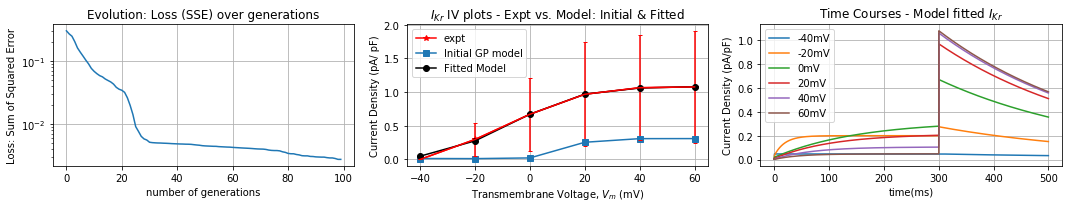

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

IkrIni, time, IKrIni_time = Ikr_func(0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24)

Ikrfit, time, IKrfit_time  = Ikr_func(6.75179737e-02, -9.23225436e+00,  1.00224281e+01,  5.62604581e+02,
  2.20935149e+01,  2.05617335e-01, -3.41704934e-01,  1.60699851e+01,
  3.15075992e-01,  4.90484972e+02,  3.08905343e+01,  3.91636784e+01,
  5.09891436e+01,  2.09719665e+01)
Ikr_act = np.array(
    [0.0000, 0.296491453, 0.670409, 0.967468331, 1.064629846, 1.076653804 ])
Ikr_err = np.array([0.000, 0.246868565, 0.539902624, 0.771099748, 0.782198549, 0.832950241])

Vcm = np.arange(-40, 61, 20)

ini_r2 = r2_score(Ikr_act, IkrIni)
fit_r2 = r2_score(Ikr_act, Ikrfit)

print('Initial Model Goodness of fit, R_sq = %s' %ini_r2)
print('GA fitted Model Goodness of fit, R_sq = %s' %fit_r2)

ini_param = np.array([0.035, 10, 5, 550, 22, 9, 6, 11, 9, 230, 40, 20, 74, 24])
fin_param = np.array([6.75179737e-02, -9.23225436e+00,  1.00224281e+01,  5.62604581e+02,
  2.20935149e+01,  2.05617335e-01, -3.41704934e-01,  1.60699851e+01,
  3.15075992e-01,  4.90484972e+02,  3.08905343e+01,  3.91636784e+01,
  5.09891436e+01,  2.09719665e+01])
percent_change = ((fin_param - ini_param)/ini_param)*100

print('percent change:', percent_change)

plt.figure(figsize=(15,3))
plt.subplot(1,3,3)
plt.plot(time, IKrfit_time)
plt.xlabel('time(ms)')
plt.ylabel('Current Density (pA/pF)')
plt.title('Time Courses - Model fitted $I_{Kr}$')
plt.legend(['-40mV', '-20mV', '0mV', '20mV', '40mV', '60mV'], loc='best')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Vcm, Ikr_act, 'r-*', label = 'expt') #experimental plot
plt.plot(Vcm, IkrIni, '-s', label='Initial GP model')  #initial model plot
plt.plot(Vcm, Ikrfit, 'k-o', label='Fitted Model') #modelfitted
plt.errorbar(Vcm, Ikr_act, yerr=Ikr_err, capsize=2, color = 'red') #errorbar experimental data
plt.xlabel('Transmembrane Voltage, $V_m$ (mV)')
plt.ylabel('Current Density (pA/ pF)')
plt.title('$I_{Kr}$ IV plots - Expt vs. Model: Initial & Fitted')
plt.grid()
plt.legend(loc='best')

plt.subplot(1,3,1)
gen_num = np.arange(len(best_gen_fitness))
plt.plot(gen_num[:100], best_gen_fitness[:100])
plt.yscale('log')
plt.xlabel('number of generations')
plt.ylabel('Loss: Sum of Squared Error')
plt.title('Evolution: Loss (SSE) over generations')
plt.grid()
plt.tight_layout()
plt.show()
